# Training Testing
Membuat testing untuk Capstone Project Bangkit

In [1]:
!python3 --version

Python 3.10.12


In [3]:
import re
import csv
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import tensorflowjs as tfjs

import pickle

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

from sklearn.metrics import classification_report

2023-12-18 10:45:15.066957: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 10:45:15.427482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 10:45:15.427517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 10:45:15.489310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 10:45:15.609445: I tensorflow/core/platform/cpu_feature_guar

## Hapus Stopwords
Menghapus kata yang tidak penting.

In [4]:
stopwords_list = set(stopwords.words('english'))
stopwords_list = list(stopwords_list)

other_stopword = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
    'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',
    'skills', 'details', 'associate',
    'company', 'description', 'assisted', 'review', 'tar', 'core', 'member',
    'team', 'helped', 'automated', 'scratch', 'assisting',
    'discovery', 'domain', 'predictive', 'topic', 'automating',
    'reduced', 'labor', 'costs', 'time', 'spent', 'lawyers', 'understand',
    'end', 'flow', 'identify',
    'red', 'flags', 'fraud-related', 'issues', 'tools', 'multiple',
    'usa', 'clients', 'motor', 'vehicle', 'customer', 'survey', 'positive', 'negative', 'neutral',
    'time', 'series', 'heat', 'map', 'terms', 'words', 'extracted', 'word', 'cloud',
    'created', 'customized', 'tableau', 'chatbot', 'user', 'friendly', 'handle',
    'simple', 'questions', 'hours', 'operation', 'reservation', 'options', 'build',
    'pipeline', 'giving', 'overview', 'qa', 'platform', 'recommendation', 'responses', 'build',
    'chain', 'relevant', 'answer', 'information', 'governance', 'organizations', 'make', 'informed',
    'decisions', 'integrated', 'portfolio', 'synthesizes', 'intelligence', 'unstructured', 'sources',
    'facilitates', 'action', 'ensure', 'best', 'positioned', 'counter', 'information', 'risk',
    'scan', 'data', 'multiple', 'parse', 'file', 'formats', 'extract', 'meta', 'results', 'indexing',
    'elastic', 'search', 'created', 'rot', 'redundant', 'outdated', 'trivial',
    'full-text', 'predefined', 'methods', 'tag', 'pii', 'personally', 'identifiable', 'social', 'security',
    'numbers', 'addresses', 'names', 'frequently', 'targeted', 'cyber-attacks', 'fraud', 'platform',
    'red', 'flag', 'cases', 'fap', 'fraud', 'inbuilt', 'case', 'manager',
    'suite', 'erp', 'systems', 'used', 'clients', 'interrogate', 'anomalies', 'indicators',
    'advanced']

ps = PorterStemmer()

def removeStopwords(sentence, stopwords = stopwords_list):
    final_sentence = []

    sentence = re.sub(r"http\S+\s*", " ", sentence.lower())
    sentence = re.sub(r"RT|cc", r" ", sentence)
    sentence = re.sub(r"#\S+", r" ", sentence)
    sentence = re.sub(r"@\S+", r" ", sentence)
    sentence = re.sub(r'\d+', '', sentence)
    sentence = re.sub("[%s]" % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), r" ", sentence)
    sentence = re.sub(r"[^\x00-\x7f]", r" ", sentence)
    sentence = re.sub(r"\s+", r" ", sentence)

    for word in sentence.split():
        if word not in stopwords and word.isalpha() and word not in other_stopword:
            final_sentence.append(ps.stem(word))
    sentence = " ".join(final_sentence)

    return sentence

## Fungsi untuk mendapatkan teks dan labelnya.
Untuk kategori dari pekerja.

In [5]:
def parseDataFromData(file):
    categories = []
    sentences = []

    with open(file, "r", encoding = "utf-8") as csvfile:
        reader = csv.reader(csvfile, delimiter = ",")
        next(reader)
        rows = list(reader)
        random.shuffle(rows)
        for row in rows:
            categories.append(row[0].replace(" ", "").replace("-", "").lower())
            sentences.append(removeStopwords(row[1]))

    return sentences, categories

## Pemotongan untuk Validasi

Pembagian data untuk tarining dan validasi (test).

In [6]:
def splitData(sentences, categories, num_split):
    trainSize = int(len(sentences) * num_split)

    trainingSentences = sentences[:trainSize]
    trainingCategories = categories[:trainSize]

    validationSentences = sentences[trainSize:]
    validationCategories = categories[trainSize:]

    return trainingSentences, trainingCategories, validationSentences, validationCategories

## Tokenization

In [7]:
def tokenizerSentences(sentences, vocab_size, oov_token):
    tokenizerSentences = Tokenizer(num_words = vocab_size, oov_token = oov_token)
    tokenizerSentences.fit_on_texts(sentences)

    return tokenizerSentences

In [8]:
def tokenizerCategories(categories):
    categoriesTokenizer = Tokenizer()
    categoriesTokenizer.fit_on_texts(categories)

    return categoriesTokenizer

## Sequences

In [9]:
def sequencesSentences(sentences, sentences_tokenizer, padding, truncating, maxlen):
    sequencesSentencesData = sentences_tokenizer.texts_to_sequences(sentences)
    padTruncSequences = pad_sequences(sequencesSentencesData, maxlen = maxlen, padding = padding, truncating = truncating)

    return np.array(padTruncSequences)

In [10]:
def sequencesCategories(categories_tokenizer, split_categories):
    sequencesCategoriesData = categories_tokenizer.texts_to_sequences(split_categories)

    return np.array(sequencesCategoriesData) - 1

## Model

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get("accuracy") > 0.95 and logs.get("val_accuracy") > 0.87):
            print("\nCancelling Training!")
            self.model.stop_training = True

In [12]:
def createModel(vocab_size, embedding_dim, maxlen, output_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(output_size, activation="softmax")
    ])
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="Adam",
        metrics=["accuracy"],
    )

    model.summary()

    return model

In [13]:
def trainingHistory(model, epochs, train_pad_trunc_seq, train_categories_seq, val_pad_trunc_seq, val_categories_seq, verbose, callbacks):
    history = model.fit(train_pad_trunc_seq, train_categories_seq, epochs=epochs, validation_data=(val_pad_trunc_seq, val_categories_seq), verbose=2, callbacks=[callbacks])

    return history

## Detection
Testing untuk deteksi akurasi model

In [34]:
def detection(model, sentences_tokenizer, example_sentences, padding, truncating, maxlen):
    exampleSequence = sentences_tokenizer.texts_to_sequences([example_sentences])
    examplePadded = pad_sequences(exampleSequence, maxlen = maxlen, padding = padding, truncating = truncating)
    prediction = model.predict(np.array(examplePadded))

    return prediction

In [32]:
def detectionFromFile(model, sentences_tokenizer_pkl, example_sentences, padding, truncating, maxlen):
    with open(sentences_tokenizer_pkl, 'rb') as handle:
      loaded_tokenizer = pickle.load(handle)

    exampleSequence = loaded_tokenizer.texts_to_sequences([example_sentences])
    examplePadded = pad_sequences(exampleSequence, maxlen = maxlen, padding = padding, truncating = truncating)

    prediction = model.predict(np.array(examplePadded))

    return prediction

## Grafik Loss

In [16]:
def lossGraphic(history, epochs):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = [*range(int(epochs))]

    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss", "Validation Loss"])
    plt.show()

## Grafik Accuracy

In [17]:
def accGraphic(history, epochs):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    epochs = [*range(int(epochs))]

    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Accuracy", "Validation Accuracy"])
    plt.show()

## Mendapatkan Banyak Kategori

In [18]:
def categoriesLength(categoriesTokenizer):
    return len(dict(list(categoriesTokenizer.word_index.items())))

# Creating Model

Membuat model dari machine learning

In [5]:
TRAINING_SPLIT = 0.8
OOV_TOKEN = "<OOV>"
PADDING = "post"
TRUNCATING = "post"
EMBEDDING_DIM = 64
VOCAB_SIZE = 6000
MAXLEN = 800
EPOCHS = 200

In [20]:
sentences, categories = parseDataFromData("Dataset.csv")

print("Total Data: ")
print("   Sentences: " + str(len(sentences)))
print("   Categories: " + str(len(categories)))
print(" ")

print("First Example: ")
print("   Sentences: \n")
print(str(sentences[0]) + "\n")
print("   Categories: \n")
print(str(categories[0]))
print(" ")

Total Data: 
   Sentences: 3327
   Categories: 3327
 
First Example: 
   Sentences: 

director busi develop summari dedic driven sale market strategist year experi softwar industri proven abil research develop implement technic sale market plan expert technic content develop sale collater effect reinforc solut benefit skill writer trainer present fast learner work well pressur commit su ess highlight director busi develop privaci llc dedic driven sale market strategist year experi softwar industri proven abil research develop implement technic sale market plan expert technic content develop sale collater effect reinforc solut benefit skill writer trainer present fast learner work well pressur commit su ess compet presal implement support develop market strategi competit analysi market research develop train materi product posit brand product demonstr develop sale collater public media relat web print content develop client support post sale abil listen relay busi need technic develop t

In [21]:
tokenizerSentencesData = tokenizerSentences(sentences, VOCAB_SIZE, OOV_TOKEN)
sequencesSentencesData = sequencesSentences(sentences, tokenizerSentencesData, PADDING, TRUNCATING, MAXLEN)

tokenizerCategoriesData = tokenizerCategories(categories)
sequencesCategoriesData = sequencesCategories(tokenizerCategoriesData, categories)

# smote = SMOTE(sampling_strategy = "minority", random_state = 42)
# sequencesSentences, sequencesCategories = smote.fit_resample(sequencesSentencesData, sequencesCategoriesData)

trainingSentences, trainingCategories, validationSentences, validationCategories = splitData(sequencesSentencesData, sequencesCategoriesData, TRAINING_SPLIT)

print("Category Length: " + str(categoriesLength(tokenizerCategoriesData)) + "\n")
print(dict(list(tokenizerCategoriesData.word_index.items())))
print(" ")

print("Total Data: ")
print("   Training Sentences: " + str(len(trainingSentences)))
print("   Validation Sentences: " + str(len(trainingCategories)))
print("   Training Categories: " + str(len(validationSentences)))
print("   Validation Categories: " + str(len(validationCategories)))
print(" ")

Category Length: 45

{'sales': 1, 'advocate': 2, 'businessdevelopment': 3, 'chef': 4, 'fitness': 5, 'healthcare': 6, 'hr': 7, 'finance': 8, 'engineering': 9, 'informationtechnology': 10, 'banking': 11, 'accountant': 12, 'consultant': 13, 'aviation': 14, 'construction': 15, 'publicrelations': 16, 'arts': 17, 'designer': 18, 'digitalmedia': 19, 'teacher': 20, 'apparel': 21, 'agriculture': 22, 'automobile': 23, 'bpo': 24, 'javadeveloper': 25, 'database': 26, 'datascience': 27, 'devopsengineer': 28, 'dotnetdeveloper': 29, 'hadoop': 30, 'testing': 31, 'automationtesting': 32, 'businessanalyst': 33, 'pythondeveloper': 34, 'healthandfitness': 35, 'civilengineer': 36, 'sapdeveloper': 37, 'networksecurityengineer': 38, 'etldeveloper': 39, 'blockchain': 40, 'mechanicalengineer': 41, 'electricalengineering': 42, 'webdesigning': 43, 'operationsmanager': 44, 'pmo': 45}
 
Total Data: 
   Training Sentences: 2661
   Validation Sentences: 2661
   Training Categories: 666
   Validation Categories: 666


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 800, 64)           384000    
                                                                 
 conv1d_2 (Conv1D)           (None, 800, 128)          41088     
                                                                 
 dropout_4 (Dropout)         (None, 800, 128)          0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 400, 128)          0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               6553728   
                                                      

ValueError: ignored

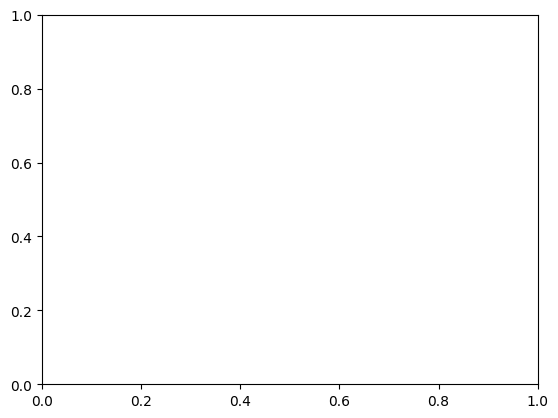

In [31]:
callbacks = myCallback()
model = createModel(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, categoriesLength(tokenizerCategoriesData))
history = trainingHistory(model, EPOCHS, trainingSentences, trainingCategories, validationSentences, validationCategories, 2, callbacks)

lossGraphic(history, EPOCHS)
accGraphic(history, EPOCHS)

In [32]:
prediction = model.predict(validationSentences)

y_test = validationCategories.flatten()
y_pred = [np.argmax(pred) for pred in prediction]

print(classification_report(y_test, y_pred))

21/21 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.85      0.97      0.90        29
           1       0.92      0.76      0.83        29
           2       1.00      1.00      1.00        43
           3       1.00      0.88      0.94        33
           4       0.93      0.68      0.78        40
           5       0.72      0.82      0.77        28
           6       1.00      1.00      1.00        36
           7       0.92      1.00      0.96        23
           8       1.00      0.89      0.94        27
           9       0.83      1.00      0.91        30
          10       1.00      1.00      1.00        31
          11       0.95      0.69      0.80        26
          12       0.96      1.00      0.98        22
          13       0.96      0.92      0.94        26
          14       1.00      0.96      0.98        24
          15       0.68      0.85      0.76        20
          16       0.93     

In [35]:
import pickle
model.save("/content/drive/MyDrive/Project/model/modelT.h5")
tfjs.converters.save_keras_model(model, "/content/drive/MyDrive/Project/checkpoint/model terbaru/")

with open('/content/drive/MyDrive/Project/sentence/tokenizer_sentencesT.pkl', 'wb') as handle:
    pickle.dump(tokenizerSentencesData, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Project/label/dictionaryT.pkl', 'wb') as handle:
    pickle.dump(tokenizerCategoriesData, handle, protocol=pickle.HIGHEST_PROTOCOL)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 64)           384000    
                                                                 
 conv1d_2 (Conv1D)           (None, 150, 128)          41088     
                                                                 
 dropout_6 (Dropout)         (None, 150, 128)          0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 75, 128)           0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 9600)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1228928   
                                                      

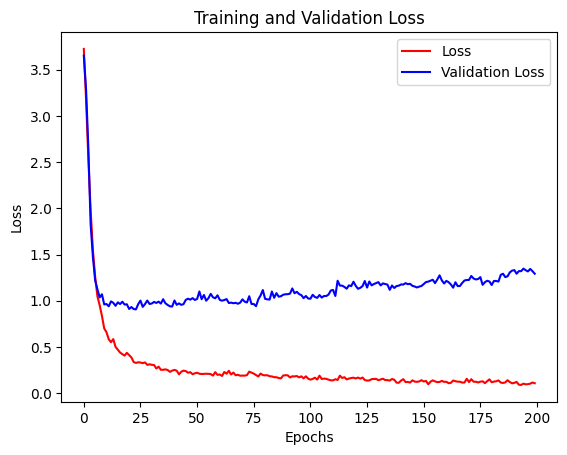

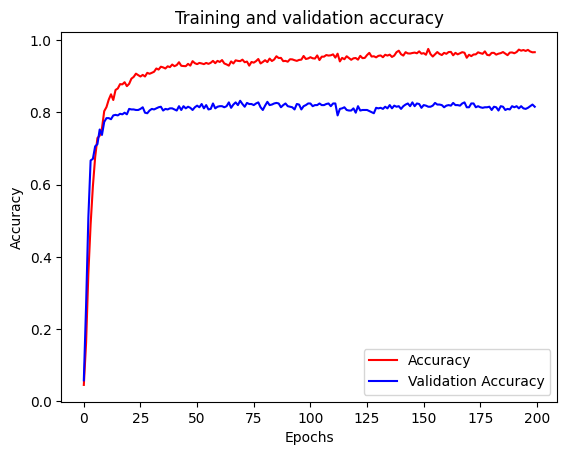

In [ ]:
callbacks = myCallback()
model = createModel(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, categoriesLength(tokenizerCategoriesData))
history = trainingHistory(model, EPOCHS, trainingSentences, trainingCategories, validationSentences, validationCategories, 2, callbacks)

lossGraphic(history, EPOCHS)
accGraphic(history, EPOCHS)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 800, 64)           384000    
                                                                 
 conv1d_4 (Conv1D)           (None, 800, 128)          41088     
                                                                 
 dropout_8 (Dropout)         (None, 800, 128)          0         
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 400, 128)          0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 51200)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               6553728   
                                                      

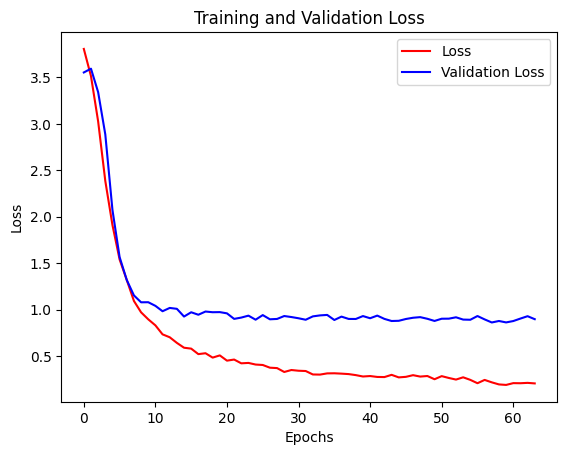

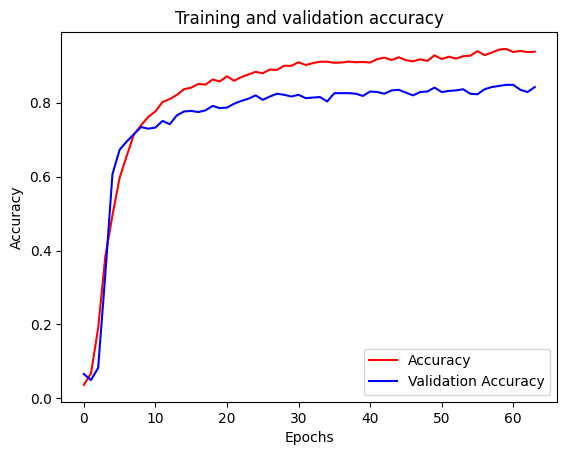

In [ ]:
callbacks = myCallback()
model = createModel(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, categoriesLength(tokenizerCategoriesData))
history = trainingHistory(model, EPOCHS, trainingSentences, trainingCategories, validationSentences, validationCategories, 2, callbacks)

lossGraphic(history, EPOCHS)
accGraphic(history, EPOCHS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 800, 64)           384000    
                                                                 
 conv1d_1 (Conv1D)           (None, 800, 128)          41088     
                                                                 
 dropout_2 (Dropout)         (None, 800, 128)          0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 400, 128)          0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               6553728   
                                                      

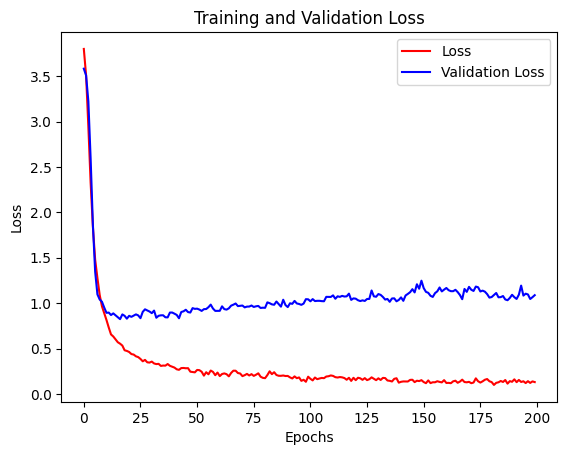

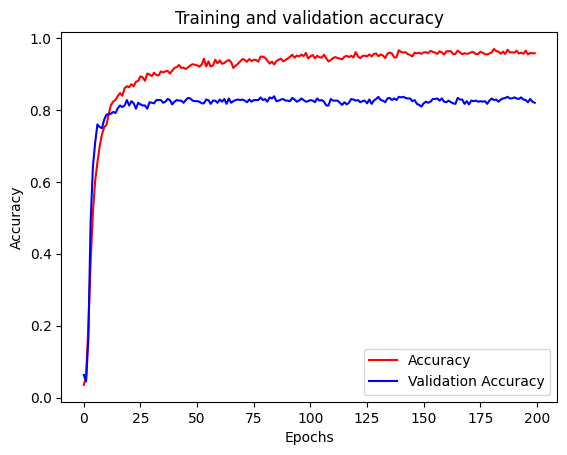

In [ ]:
callbacks = myCallback()
model = createModel(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, categoriesLength(tokenizerCategoriesData))
history = trainingHistory(model, EPOCHS, trainingSentences, trainingCategories, validationSentences, validationCategories, 1, callbacks)

lossGraphic(history, EPOCHS)
accGraphic(history, EPOCHS)

In [ ]:
prediction = model.predict(validationSentences)

y_test = validationCategories.flatten()
y_pred = [np.argmax(pred) for pred in prediction]

print(classification_report(y_test, y_pred))

21/21 [==============================] - 2s 66ms/step
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        34
           1       0.92      0.61      0.73        36
           2       0.91      1.00      0.95        30
           3       0.93      0.81      0.86        31
           4       0.74      0.77      0.76        22
           5       0.97      1.00      0.98        28
           6       0.90      0.75      0.82        36
           7       1.00      1.00      1.00        33
           8       0.90      0.82      0.86        33
           9       0.77      0.95      0.85        21
          10       1.00      0.70      0.82        30
          11       1.00      1.00      1.00        22
          12       0.91      0.91      0.91        34
          13       1.00      0.79      0.88        24
          14       0.92      0.89      0.91        27
          15       0.69      0.74      0.71        34
          16       0.57    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 64)           384000    
                                                                 
 conv1d_2 (Conv1D)           (None, 150, 128)          41088     
                                                                 
 dropout_5 (Dropout)         (None, 150, 128)          0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 75, 128)           0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 9600)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1228928   
                                                      

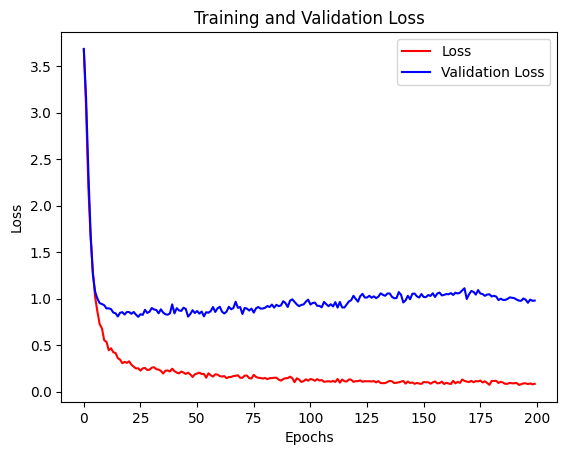

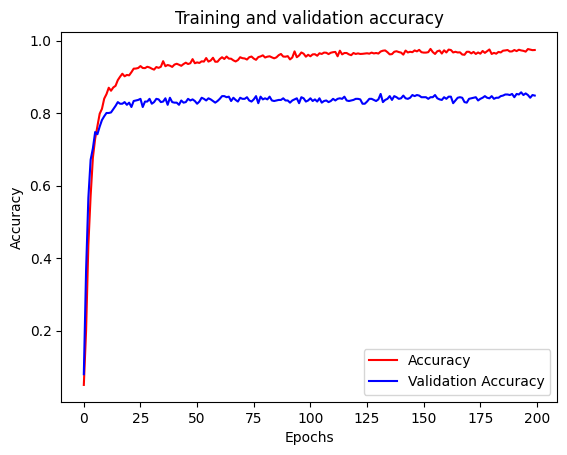

In [ ]:
callbacks = myCallback()
model = createModel(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, categoriesLength(tokenizerCategoriesData))
history = trainingHistory(model, EPOCHS, trainingSentences, trainingCategories, validationSentences, validationCategories, 2, callbacks)

lossGraphic(history, EPOCHS)
accGraphic(history, EPOCHS)

2023-12-17 21:13:25.891300: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-17 21:13:26.071178: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-17 21:13:26.071225: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-17 21:13:26.075339: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-17 21:13:26.075401: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 800, 64)           384000    
                                                                 
 conv1d (Conv1D)             (None, 796, 128)          41088     
                                                                 
 dropout (Dropout)           (None, 796, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 398, 128)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 50944)             0         
                                                                 
 dense (Dense)               (None, 128)               6520960   
                                                        

2023-12-17 21:13:27.835135: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-17 21:13:28.162977: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-17 21:13:28.677795: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-17 21:13:29.530338: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0563cda610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-17 21:13:29.530388: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-12-17 21:13:29.545400: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702818809.637597    1549 devic

84/84 - 13s - loss: 3.8478 - accuracy: 0.0368 - val_loss: 3.5621 - val_accuracy: 0.0706 - 13s/epoch - 159ms/step
Epoch 2/200
84/84 - 7s - loss: 3.5128 - accuracy: 0.0564 - val_loss: 3.4660 - val_accuracy: 0.0360 - 7s/epoch - 83ms/step
Epoch 3/200
84/84 - 6s - loss: 3.1611 - accuracy: 0.1255 - val_loss: 3.3048 - val_accuracy: 0.1637 - 6s/epoch - 68ms/step
Epoch 4/200
84/84 - 6s - loss: 2.7372 - accuracy: 0.2383 - val_loss: 2.9493 - val_accuracy: 0.2297 - 6s/epoch - 68ms/step
Epoch 5/200
84/84 - 5s - loss: 2.2869 - accuracy: 0.3687 - val_loss: 2.4294 - val_accuracy: 0.4565 - 5s/epoch - 56ms/step
Epoch 6/200
84/84 - 4s - loss: 1.8523 - accuracy: 0.4972 - val_loss: 1.8356 - val_accuracy: 0.5901 - 4s/epoch - 42ms/step
Epoch 7/200
84/84 - 3s - loss: 1.6181 - accuracy: 0.5629 - val_loss: 1.5266 - val_accuracy: 0.6276 - 3s/epoch - 34ms/step
Epoch 8/200
84/84 - 2s - loss: 1.3798 - accuracy: 0.6231 - val_loss: 1.3586 - val_accuracy: 0.6502 - 2s/epoch - 29ms/step
Epoch 9/200
84/84 - 2s - loss: 1.

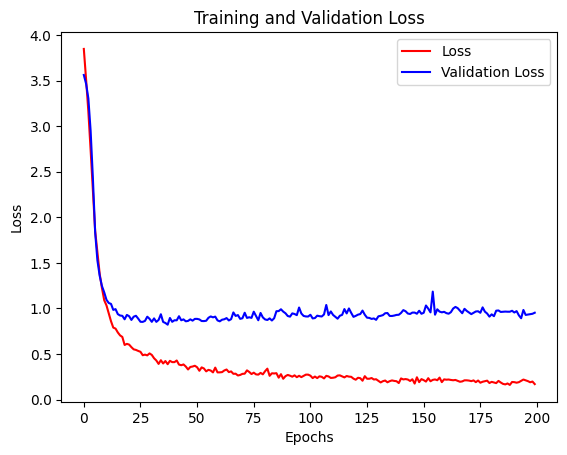

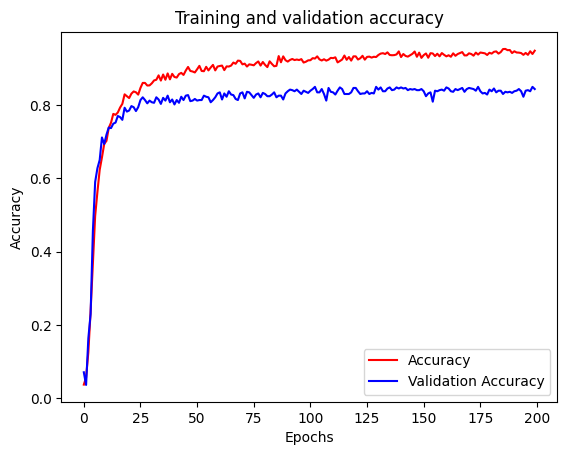

21/21 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        34
           1       0.57      0.92      0.71        26
           2       0.93      0.97      0.95        29
           3       1.00      0.86      0.92        28
           4       0.89      0.74      0.81        34
           5       0.88      0.81      0.84        26
           6       0.95      1.00      0.97        19
           7       0.97      1.00      0.98        30
           8       0.81      1.00      0.90        30
           9       0.90      0.88      0.89        32
          10       0.74      0.68      0.71        25
          11       0.97      1.00      0.98        30
          12       0.82      0.93      0.87        30
          13       0.96      0.83      0.89        29
          14       0.96      0.96      0.96        27
          15       0.88      0.78      0.82        27
          16       0.82     

/home/darel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/darel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/darel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
callbacks = myCallback()
model = createModel(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, categoriesLength(tokenizerCategoriesData))
history = trainingHistory(model, EPOCHS, trainingSentences, trainingCategories, validationSentences, validationCategories, 2, callbacks)

lossGraphic(history, EPOCHS)
accGraphic(history, EPOCHS)

prediction = model.predict(validationSentences)

y_test = validationCategories.flatten()
y_pred = [np.argmax(pred) for pred in prediction]

print(classification_report(y_test, y_pred))

In [23]:
model.save("model_17-12-23.h5")
tfjs.converters.save_keras_model(model, "tfds/")

with open('tokenizer_sentences.pkl', 'wb') as handle:
    pickle.dump(tokenizerSentencesData, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('dictionary.pkl', 'wb') as handle:
    pickle.dump(tokenizerCategoriesData, handle, protocol=pickle.HIGHEST_PROTOCOL)

/home/darel/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
import json

with open('tokenizer_sentences.pkl', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

vocab = {}

for word, index in loaded_tokenizer.word_index.items():
  if index <= VOCAB_SIZE:
    vocab[word] = index

with open('tokenizer_sentences.json', 'w') as fileH:
    json.dump(vocab, fileH)

In [6]:
import json

with open('dictionary.pkl', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

vocab = {}

for word, index in loaded_tokenizer.word_index.items():
  # if index <= VOCAB_SIZE:
  vocab[word] = index

with open('dictionary.json', 'w') as fileH:
    json.dump(vocab, fileH)

In [35]:
# resume_example = """
#           Summary Teacher devoted to helping children think creatively, solve problems independently and respect themselves and others. Teacher focused on implementing highly effective instructional practices to improve student learning and academic performance.        Highlights          Friendly.  Complex problem solver,  Active listener  Reliable and punctual   Excellent communication skills  Cheerful and energetic      Qualified tutor  Charting and recordkeeping  Positive reinforcement methods  Skilled in working with special needs children   Approachable  Complex problem solver            Experience      teacher    August 2005   to   January 2016     Company Name   ï¼   City  ,   State            teacher    January 1997   to   January 2004     Company Name   ï¼   City  ,   State            teacher    January 1986   to   January 1989     Company Name   ï¼   City  ,   State      Skills Proficiency in Microsoft Office Capable of integrating these programs with the coursework taught Sound decision maker Giving recommendations and opinions to school management upon their requests Discipline students Setting basic class rules by encouraging student feedback Patience Encouraging students to express their discomforts and catering to them in timely manner Giving personalized attention to students Time management Breaking up grading material in small groups in order to evaluate them timely Structuring tasks based on priorities Proficiency in mathematics and science More than 20 years of teaching experience in Mathematics and Science Purposeful lesson planning Making flexible lesson plans based on promoting students' critical and analytic capabilities Self-motivated Fast learner Learned various mathematics software's such as 'graph master' in a relatively short period.          Education      Masters in Education   :   Education  ,   1992    Government College of Education   ï¼   City  ,   State  ,   Pakistan            Bachelor of Education : Education, 1990 Government College of Education ï¼ City, State, Pakistan Bachelor of Science : Biology, Chemistry, 1986 Karachi University ï¼ City, State, Pakistan BSc : Biology, Chemistry, 1986 Karachi University ï¼ City, State, Pakistan Skills basic, lesson planning, lesson plans, Mathematics, Microsoft Office, express, Fast learner, Self-motivated, Sound, teaching, Time management
# """

# resume_example = """
# 7 years of experience as a Developer using Python and Django FLASK Experience with Flask highlevel Python Web frameworks Excellent knowledge of OOPS MultiThreading and Collections concepts and in Python Experienced in installing configuring modifying testing and deploying applications with Apache Experience objectoriented programming OOP concepts using Python Experienced in developing webbased applications using Python Django XML CSS HTML and JavaScript Experience with Requests Numpy and Pandas python libraries during development lifecycle Experience in developing python scripts for automation and performing functional tests and data validation Well versed with design and development of presentation layer for web applications using technologies like HTML CSS Bootstrap and JavaScript Familiar with JSON based RESTWebservices Good experience with Amazon Cloud EC2 and Simple Storage Service S3 Expertise in working with serverside technologies including databases Restful API and MVC design patterns Hands on Experience with parallel computing multithreading Experience with JSON based REST Web services Experienced in developing WebServices with Python programming language Experience in writing Sub Queries Stored Procedures and Functions on PostgreSQLand MySQLdatabase Excellent knowledge of OOPS MultiThreading and Collections concepts and in Python Strong knowledge of database concepts and both SQL and nonSQL databases Excellent debugging mathematical problem solving and optimization skills Work Experience Python Developer Validate Health Chicago IL September 2018 to Present Responsibilities Added features to an existing automation framework Python to parse data from different file format using Panda library and loaded into PostgreSQL database using an inhouse library Back end web application architecture design and development in python using Flask framework Used Python for serverside development Worked on automation setup and administration of build and deployment tools such as Jenkins Used AWS S3 Jupyter Notebook Python Developer Upwork Santa Clara CA December 2017 to March 2018 Responsibilities Used Django framework to design and develop the application Created Business Logic using Python 27 Used Django framework for application development Created database using MySQL wrote several queries and Django APIs to extract data from database Developed Python scripts using multithreading module Created the Automation scripts using Python for testing applications as well as the integration of these application APIs UIs based on REST calls using Python phrasing the JSON responses Managed large datasets using Panda data frames and SQL Used GitHubfor Python source code version control Jenkins for automation Worked on Agile Methodologies Scrum stories and sprints experience in a Python based environment Environment Python 273 Django MySQL Jenkins AWS Linux HTML CSS JSON Restful Web Services JavaScript Apache Linux Software Engineer Veritas Software India Pvt Ltd Pune Maharashtra September 2011 to May 2016 Responsibilities Implemented new testing infrastructure for the File System product to enable efficient writing of new testcases and automatic resource allocation for parallel execution of tests Python Enhanced to File Replication product in order to collect additional required metrics for performance monitoring Used FLASK framework for application development Utilized unittest the Python unit test framework for all Python applications Deployment and Build of various environments including Linux and UNIX Installed and maintained web servers Tomcat and Apache HTTP Web servers in UNIX Involved in Installation and setting up Python Linux test beds Worked with JSON based REST Web services Worked on automation setup and administration of build and deployment tools such as Jenkins Created database using MySQL wrote several queries and used FLASKto extract data from database Used GIT for the version control Environment Python 273 MySQL Windows Linux HTML CSS jQuery JavaScript Apache Linux Education Masters in Information Technology in Information Technology Indian Institute of Technology 2007 Skills DJANGO DOCKER Git HTML JAVASCRIPT FLASK XML DATABASE MYSQL POSTGRESQL SQLITE APACHE LINUX AJAX CSS DHTML ECLIPSE jQuery
# """

# resume_example = """
# STAFF ACCOUNTANT Summary Skilled Accountant successful at managing multiple projects and consistently meeting deadlines under pressure Extensive knowledge of accounting software and processes Additional ba ckground in payroll employee management hiring training and benefits Highly detail oriented and organized Highlights Financial statement analysis Account reconciliation expert General ledger accounting Effective time management Strong organizational skills Flexible team player Experience 08 2012 to Current Staff Accountant Company Name City State Process Receivables donations for 7 church locations with over 20 000 attendees and approx 45M annual revenue Process Retail Sales Revenue for multiple entities Bookstore Café Coffee Shop at each location Provide monthly financial statements and budget analysis Monthly bank reconciliations Prepare monthly Use Tax returns General Ledger review Streamline Procedures and Write Procedure Manual Assist with Accounts Payable as needed 08 2008 to 08 2012 Independent Accounting Consultant Company Name City State Provide weekly monthly quarterly and annual accounting full charge accounting services to different clients in multiple industries including but not limited to engineering marketing construction contractors subcontracting commercial leasing companies manufacturing retail Work with CPA to provide information for year end tax preparation Provide set up and ongoing consulting services to users of QuickBooks QuickBooks Pro and Quicken Assist clients in Worker s Compensation Audits Assist clients in start up of businesses Assist clients with establishing employee policies and writing company policies Full knowledge of all Payroll functions Sales Tax Reporting Financial Statement Preparation Bank Statement Reconciliations 02 2007 to 06 2010 Accounting Manager Human Resources Company Name City State Report to CFO Work directly with Directors of Marketing Agency Manage Accounts Receivable and perform monthly billing Verify all Accounts Payable transactions Process payroll using online payroll processing services Manage new employee paperwork and benefits including health dental 401K and flexible spending accounts as well as all COBRA documentation Handle all accounting duties for 2 separate smaller commercial leasing companies 05 2002 to 02 2007 Accounting and Human Resources Manager Company Name City State Report directly to President of 2 corporations and manage office of 2 separate corporations simultaneously Manage all aspects of Accounting Department and produce all necessary financial statements Process weekly payroll and payroll taxes as well as quarterly and annual payroll tax reports Researched and implemented new industry specific software to improve overall performance of business Researched implemented and maintain employee benefits program that includes 401K Health and Dental Benefits Recruit new employees and manage all personnel files Assist with employee performance evaluations and act as liaison between employees and supervisors Perform any other duties as needed including sales international business development purchasing inventory and customer service Education Bachelor of Science Business Management Arizona State University City State USA Skills Microsoft Office Word Excel Power Point Outlook Abila MIP Fund Accounting Software QuickBooks QuickBooks Pro Quicken ADP Paychex Payroll Experts QuickBooks Payroll Systems
# """

resume_example = """
Summary
Hello, my name is Darrell Rajendra Wibowo, I am an Informatics student from the Kalimantan Institute of
Technology. I am a programmer, and also like playing video games. I have the ambition to learn new things that
are fun for me. I have skills in backend development using C++, C#, Java, Python and Javascript. Apart from
programming, I also have skills in video editing.
Skills
Python (Programming Language)   •   C++   •   TensorFlow   •   Neural Networks   •   Convolutional Neural
Networks (CNN)   •   Natural Language Processing (NLP)   •   Machine Learning   •   Back-End Web
Development   •   SQL   •   Laravel
"""

loaded_model = load_model('model.h5')
prediction = detectionFromFile(loaded_model, 'tokenizer_sentences.pkl', removeStopwords(resume_example), PADDING, TRUNCATING, MAXLEN)

with open('dictionary.pkl', 'rb') as handle:
      categoriesTokenizer = pickle.load(handle)

classification_dict = dict(list(categoriesTokenizer.word_index.items()))

information = {}

for value, key in classification_dict.items():
  information[value] = (prediction[0][key - 1]) * 100

sorted_data = sorted(information.items(), key=lambda x: x[1], reverse=True)

for key, value in sorted_data:
    print(f"{key}: {value}")

1/1 [==============================] - 0s 422ms/step
datascience: 42.419517040252686
pythondeveloper: 19.43296790122986
testing: 12.57600486278534
javadeveloper: 10.899559408426285
apparel: 3.494340181350708
dotnetdeveloper: 2.5666624307632446
agriculture: 1.9378157332539558
sapdeveloper: 1.9207725301384926
civilengineer: 1.5583517029881477
businessanalyst: 0.8272257633507252
advocate: 0.5734873469918966
banking: 0.4229211714118719
hadoop: 0.1612451858818531
sales: 0.12879621936008334
webdesigning: 0.12799253454431891
blockchain: 0.11173704406246543
etldeveloper: 0.08881586836650968
bpo: 0.08176563424058259
database: 0.08154370007105172
arts: 0.07772892131470144
devopsengineer: 0.07669348851777613
operationsmanager: 0.06401717546395957
engineering: 0.04623663262464106
automobile: 0.04599773383233696
publicrelations: 0.03740884130820632
automationtesting: 0.036457538953982294
healthandfitness: 0.029234314570203424
pmo: 0.026177195832133293
aviation: 0.025902106426656246
fitness: 0.01607

In [39]:
description_example = """
Responsibilities
Contribute in all phases of the development lifecycle
Write well designed, testable, efficient code
Ensure designs are in compliance with specifications
Prepare and produce releases of software components
Support continuous improvement by investigating alternatives and technologies and presenting these for architectural review
Requirements and skills
BS/MS degree in Computer Science, Engineering or a related subject
Proven hands-on Software Development experience
Proven working experience in Java development
Hands on experience in designing and developing applications using Java EE platforms
Object Oriented analysis and design using common design patterns.
Profound insight of Java and JEE internals (Classloading, Memory Management, Transaction management etc)
Excellent knowledge of Relational Databases, SQL and ORM technologies (JPA2, Hibernate)
Experience in the Spring Framework
Experience as a Sun Certified Java Developer
Experience in developing web applications using at least one popular web framework (JSF, Wicket, GWT, Spring MVC)
Experience with test-driven development
"""

loaded_model = load_model('model.h5')
prediction = detectionFromFile(loaded_model, 'tokenizer_sentences.pkl', removeStopwords(description_example), PADDING, TRUNCATING, MAXLEN)

classification_dict = dict(list(categoriesTokenizer.word_index.items()))

information = {}

for value, key in classification_dict.items():
  information[value] = (prediction[0][key - 1]) * 100

sorted_data = sorted(information.items(), key=lambda x: x[1], reverse=True)

for key, value in sorted_data:
    print(f"{key}: {value}")

1/1 [==============================] - 0s 61ms/step
designer: 37.225937843322754
javadeveloper: 15.814419090747833
operationsmanager: 14.924558997154236
blockchain: 9.754566848278046
mechanicalengineer: 7.5866758823394775
automationtesting: 3.6512337625026703
businessanalyst: 2.18600332736969
networksecurityengineer: 2.054831385612488
consultant: 1.4391034841537476
webdesigning: 0.9952995926141739
etldeveloper: 0.9005219675600529
sapdeveloper: 0.5781474057585001
engineering: 0.514821894466877
devopsengineer: 0.4403330385684967
hadoop: 0.3789032809436321
aviation: 0.241540907882154
agriculture: 0.2300939755514264
automobile: 0.22629534360021353
construction: 0.19613499753177166
pmo: 0.14062855625525117
electricalengineering: 0.09306847932748497
dotnetdeveloper: 0.08396729826927185
banking: 0.050417432794347405
teacher: 0.04435348673723638
fitness: 0.041159201646223664
accountant: 0.036159338196739554
businessdevelopment: 0.03449486393947154
bpo: 0.032756198197603226
arts: 0.023412289738

category
sales                      155
advocate                   154
businessdevelopment        153
chef                       152
fitness                    146
hr                         144
healthcare                 144
finance                    142
engineering                141
informationtechnology      141
banking                    139
accountant                 139
consultant                 137
aviation                   134
construction               129
publicrelations            128
arts                       127
designer                   124
digitalmedia               122
teacher                    120
apparel                    113
agriculture                 74
automobile                  55
bpo                         44
javadeveloper               26
database                    22
datascience                 20
dotnetdeveloper             14
hadoop                      14
devopsengineer              14
automationtesting           14
testing                     14

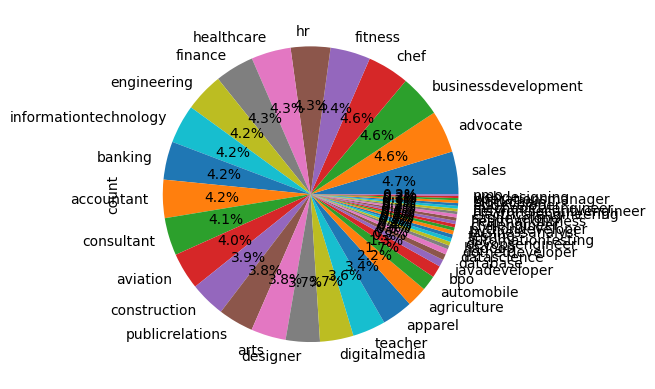

In [5]:
import pandas as pd

df = pd.read_csv("OtherSuperUltimateDataset2.csv")
df["category"].value_counts().plot(kind = "pie", autopct='%1.1f%%')

unique_categories = df["category"].value_counts()
print(unique_categories)